In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [5]:
data = pd.read_pickle("USStockData.pickle")
res = []
lis = data.keys()

for item in lis:
    temp = data[item].close
    temp = temp.to_frame()
    temp.columns = [item]
    res.append(temp)

In [6]:
df = pd.concat(res,axis=1)

In [10]:
data_last = df[df.index>'2016-01-01']

In [11]:
data_last

,MSFT,AAPL,AMZN,FB,GOOG,JNJ,JPM,V,PG,T,...,NEE,MDT,ABBV,PYPL,AMGN,TMO,LLY,HON,ACN,IBM
2016-01-04,54.80,105.35,636.99,102.22,741.84,100.48,63.62,75.70,78.37,34.35,...,103.57,75.77,57.61,34.75,158.340,138.75,82.87,102.57,101.83,135.95
2016-01-05,55.05,102.71,633.79,102.73,742.58,100.90,63.73,76.27,78.62,34.59,...,104.58,75.99,57.37,34.31,158.170,138.51,84.11,103.41,102.36,135.85
2016-01-06,54.05,100.70,632.65,102.97,743.62,100.39,62.81,75.27,77.86,34.06,...,104.24,76.20,57.38,33.98,156.720,137.45,83.58,102.24,102.16,135.17
2016-01-07,52.17,96.45,607.94,97.92,726.39,99.22,60.27,73.79,77.18,33.51,...,104.70,74.41,57.21,33.13,152.980,134.31,81.41,99.23,99.16,132.86
2016-01-08,52.33,96.96,607.05,97.33,714.47,98.16,58.92,72.88,75.97,33.54,...,105.17,73.78,55.65,32.69,150.705,134.16,81.25,98.43,98.20,131.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,298.79,165.12,3071.26,211.03,2697.82,164.57,141.80,216.12,155.89,23.69,...,78.27,104.99,147.77,111.93,226.480,544.00,249.95,189.75,316.02,122.51
2022-03-01,294.95,163.20,3022.84,203.49,2683.36,164.00,136.45,208.97,153.31,23.53,...,77.44,103.66,147.69,106.51,225.210,543.07,249.50,183.60,311.35,121.35
2022-03-02,300.19,166.56,3041.05,208.11,2695.03,166.04,139.28,208.48,153.79,23.82,...,77.55,106.38,149.57,106.61,228.590,556.45,254.17,186.44,318.33,123.86
2022-03-03,295.92,166.23,2957.97,202.97,2686.16,168.48,138.29,207.23,154.36,23.91,...,78.79,107.65,150.41,101.34,232.640,554.29,258.64,187.52,318.95,125.93


In [12]:
# Parameters Setting
initial_budget = 1000000
n_stocks = 1
trading_cost = 0.0/1000
lookback = 120
rebalance = 20
risk_aversion = 1

C:\ProgramData\Anaconda3\envs\Pricing\lib\site-packages\numpy\core\_methods.py:275: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  umr_maximum(a, axis, None, out, keepdims),
C:\ProgramData\Anaconda3\envs\Pricing\lib\site-packages\numpy\core\_methods.py:276: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  umr_minimum(a, axis, None, None, keepdims),


Annualized Return:  31.160797750989122 %
Annualized Volatility:  36.23563830543017 %
Downside Deviation:  25.46793116786675 %
Max Drawdown(in percentage):  17.147953125440708 %
Max Drawdown(in dollars):  2396818.08
Sharpe Ratio:  0.8599489124031644
Sortino Ratio:  1.223530782520142


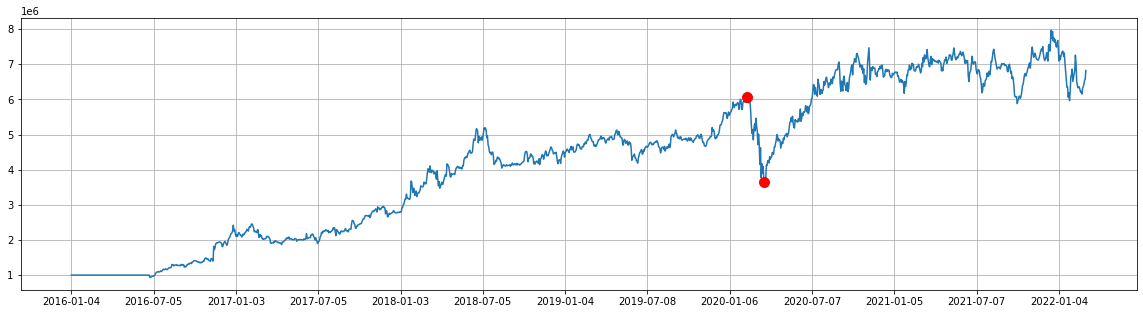

In [13]:

net_value = pd.DataFrame([0]*data_last.shape[0], index=data_last.index, columns=['net_value'])
cash = pd.DataFrame([0]*data_last.shape[0], index=data_last.index,columns=['cash'])
# Target Weight
weight = pd.DataFrame(np.zeros(shape=data_last.shape),columns=data_last.columns, index=data_last.index)
# Practical Position
stock_pos = pd.DataFrame(np.zeros(shape=data_last.shape),columns=data_last.columns, index=data_last.index)



for i in range(0,lookback):
    cash.iloc[i] = initial_budget
    net_value.iloc[i] = initial_budget


for i in range(lookback, data_last.shape[0]):
#for i in range(lookback, 160):
    today_price = data_last.iloc[i-1:i+1]
    today_ret = (today_price - today_price.shift()).iloc[1:]/today_price.shift().iloc[1]
    today_ret = today_ret.fillna(0)
    if (i-lookback)%20 == 0:
        temp = data_last.iloc[i-lookback:i-1].dropna(axis=1)
        temp_ret = (np.log(temp)).diff()[1:]
        ret = temp_ret.sum(axis=0)
        vol = temp_ret.std(axis=0)
        momentum = ret - risk_aversion * vol
        if (momentum.shape[0] >= n_stocks):
            idx_buy = momentum.nlargest(n_stocks).index
            weight.iloc[i][idx_buy] = 1.0/n_stocks
        else:
            n_mom = momentum.shape[0]
            idx_buy = momentum.nlargest(n_mom).index
            weight.iloc[i][idx_buy] = 1.0/n_mom
        if i > lookback:
            cash.iloc[i] = stock_pos.iloc[i-1][idx_pre].sum()*(1-trading_cost)+cash.iloc[i-1]
        else:
            cash.iloc[i] = cash.iloc[i-1]

        available_cash = cash.iloc[i].values[0]
        for stock_id in idx_buy:
            target_pos = weight.iloc[i][stock_id]*available_cash
            n_temp = np.floor(target_pos/(data_last.iloc[i-1][stock_id]*(1+trading_cost)))
            stock_pos.iloc[i][stock_id] = n_temp*data_last.iloc[i-1][stock_id]
            cash.iloc[i] -= n_temp*data_last.iloc[i-1][stock_id]*(1+trading_cost)
        stock_pos.iloc[i] = stock_pos.iloc[i] *(today_ret[stock_pos.columns]+1)
        idx_pre = idx_buy
    else:
        weight.iloc[i] = weight.iloc[i-1]
        stock_pos.iloc[i] = stock_pos.iloc[i-1]*(today_ret[stock_pos.columns]+1)
        cash.iloc[i] = cash.iloc[i-1]
    net_value.iloc[i] = cash.iloc[i] + sum(stock_pos.iloc[i])


ret = np.log(net_value).diff().dropna()
annual_ret = ret.mean().values[0]*252
annual_vol = ret.std().values[0]*np.sqrt(252)
sharpe = annual_ret/annual_vol
s=(ret+1).cumprod()
mdd_pct = (1-np.ptp(s)/s.max()).values[0]
mdd_usd = (net_value.cummax()-net_value).max()
mdd_usd = mdd_usd.values[0]
r_d = ret[ret<0].dropna()
down_deviation = np.sqrt(252)*(np.sqrt((0 - r_d)**2).sum())/r_d.shape[0]
down_deviation = down_deviation.values[0]
sortino = annual_ret/ down_deviation

print("Annualized Return: ", annual_ret*100, "%")
print("Annualized Volatility: ", annual_vol*100, "%")
print("Downside Deviation: ", down_deviation*100, "%")
print("Max Drawdown(in percentage): ", mdd_pct*100, "%")
print("Max Drawdown(in dollars): ", mdd_usd)
print("Sharpe Ratio: ", sharpe)
print("Sortino Ratio: ", sortino)


fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
i = np.argmax(np.maximum.accumulate(net_value) - net_value) # end of the period
j = np.argmax(net_value[:i]) # start of period
ax.plot(net_value)
ax.plot([net_value.index[i], net_value.index[j]], [net_value.iloc[i], net_value.iloc[j]], 'o', color='Red', markersize=10)
tick_space = 126
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_space))
plt.grid()
plt.show()

In [14]:
stock_pos

,MSFT,AAPL,AMZN,FB,GOOG,JNJ,JPM,V,PG,T,...,NEE,MDT,ABBV,PYPL,AMGN,TMO,LLY,HON,ACN,IBM
2016-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
